Create auxilary functions for data generation.

In [47]:
import PolynomialRoots.roots
using Distributions
using Plots

function generate_coefficients(order::Int)
    stable = false
    true_a = []
    # Keep generating coefficients until we come across a set of coefficients
    # that correspond to stable poles
    while !stable
        true_a = randn(order)
        coefs =  append!([1.0], -true_a)
        if false in ([abs(root) for root in roots(coefs)] .> 1)
            continue
        else
            stable = true
        end
    end
    return true_a
end

function generateAR(num::Int, order::Int; nvar=1, stat=true, coefs=nothing)
    if isnothing(coefs) && stat
        coefs = generate_coefficients(order)
    else
        coefs = randn(order)
    end
    inits = randn(order)
    data = Vector{Vector{Float64}}(undef, num+3*order)
    data[1] = inits
    for i in 2:num+3*order
        data[i] = insert!(data[i-1][1:end-1], 1, rand(Distributions.Normal(coefs'data[i-1], sqrt(nvar[])), 1)[1])
    end
    data = data[1+3*order:end]
    return coefs, data
end

generateAR (generic function with 1 method)

In [362]:
using Random
Random.seed!(0)

n_datasets = 1
n_samples = 100
AR_z = 4:8
AR_x = 1:4
noise_var = [1.0, 0.3, 0.1]
SNR_s = rand(noise_var, n_datasets)
speech_data, noise_data = [generateAR(100, rand(AR_z)) for _ in 1:n_datasets], [generateAR(100, rand(AR_x), nvar=SNR_s[i]) for i in 1:n_datasets];

In [355]:
plot(first.(speech_data[20][2]))
plot!(first.(noise_data[20][2]), label=SNR_s[20])
output = first.(speech_data[20][2]) + first.(noise_data[20][2])
scatter!(output)

LoadError: BoundsError: attempt to access 1-element Vector{Tuple{Vector{Float64}, Vector{Vector{Float64}}}} at index [20]

In [357]:
using AIDA
using ReactiveMP
import ProgressMeter

### Coupled AR inference

In [367]:
vmp_its = 500

rmx = zeros(n_datasets, n_samples)
rvx = zeros(n_datasets, n_samples)
rmθ, rvθ = [], []
rγ = fill(tuple(.0, .0), n_datasets)

rmz = zeros(n_datasets, n_samples)
rvz = zeros(n_datasets, n_samples)
rmη, rvη  = [], []
rτ = fill(tuple(.0, .0), n_datasets)

fe  = zeros(n_datasets, vmp_its)

ProgressMeter.@showprogress for i in 1:n_datasets
    
    output = first.(speech_data[i][2]) + first.(noise_data[i][2])
    ar_speech, ar_env = length(speech_data[i][1]), length(noise_data[i][1])
    
    priors_mη, priors_vη, priors_τ = prior_to_priors(zeros(ar_env), diageye(ar_env), (1.0, SNR_s[i]), n_samples, ar_env)
    
    prior_η                           = (priors_mη[i, :], priors_vη[i, :, :])
    prior_τ                           = priors_τ[i]
    γ, θ, zs, τ, η, xs, fe[i, :]      = coupled_inference(output, prior_η, prior_τ, ar_speech, ar_env, vmp_its)
    mz, vz                            = mean.(zs), cov.(zs)
    mθ, vθ                            = mean(θ), cov(θ)
    rmz[i, :], rvz[i, :]              = first.(mz), first.(vz)
    
    push!(rmθ, mθ)
    push!(rvθ, vθ)
    
    rγ[i]                             = shape(γ), rate(γ)
    
    mx, vx                            = mean.(xs), cov.(xs)
    mη, vη                            = mean(η), cov(η)
    rmx[i, :], rvx[i, :]              = first.(mx), first.(vx)
    push!(rmη, mη)
    push!(rvη, vη)
    rτ[i]                             = shape(τ), rate(τ)

end

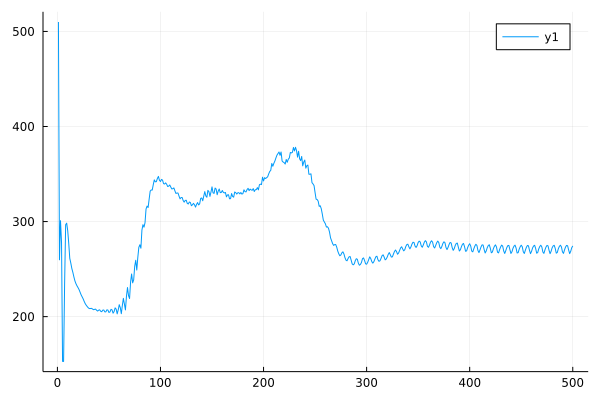

In [368]:
plot(sum(fe, dims=1)')

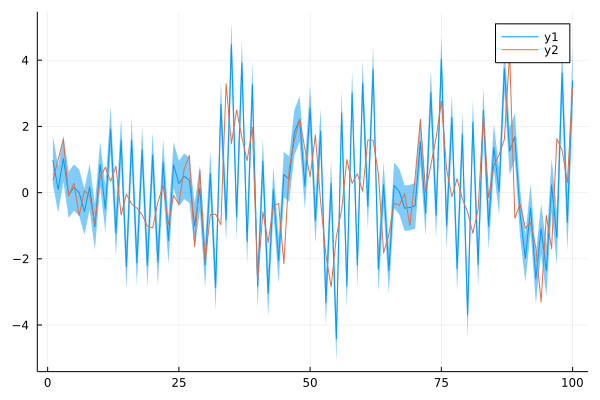

In [365]:
index = 1
plot(rmz[index, :], ribbon=sqrt.(rvz[index, :]))
plot!(first.(speech_data[index][2]))

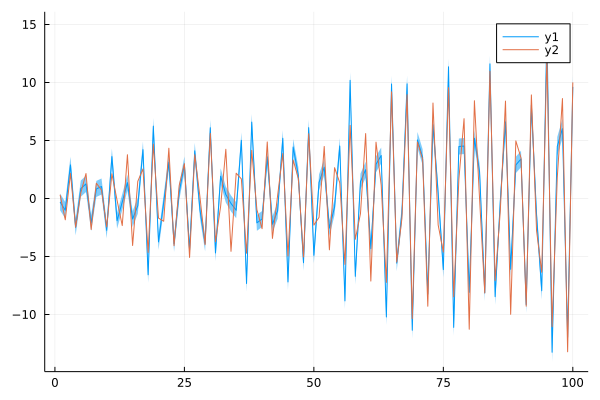

In [366]:
plot(rmx[index, :], ribbon=sqrt.(rvx[index, :]))
plot!(first.(noise_data[index][2]))

### FE 

In [330]:
rmθ

100-element Vector{Any}:
 [0.4091405826245787, -0.48202323081717, 0.5660834829955043, -0.47237378825008847]
 [1.1909971207079595, -1.0642060350007283, 0.4398732222322739, -0.2924347329814314, 0.27037319344367505]
 [1.12450414055309, -1.2261461240785252, 0.6424894421144463, -0.11763646048042697, 0.01380779145869071]
 [-0.9591457037670916, -0.03585628881205638, 0.3513982632821969, 0.08981687606417355, -0.3966842485895641, 0.03241160400925658, 0.22287390219464537, 0.07357280260124399]
 [0.8155413236873473, -0.12957501239127084, 0.19533568887062908, -0.13563774299163434, 0.2465847124460548, -0.2997455016275318]
 [-0.8396382707120393, -0.26546698816831243, -0.20827482430318378, -0.6910092514521203, -0.20781828760056392, 0.24098416504308834, 0.1796688647798822]
 [-0.8496152782024203, -0.2409696163884943, 0.3451769478194062, 0.10140607429233484, -0.18046624925151156, 0.04752021164453801]
 [1.4363161661853776, -1.1228823149821794, 0.787985829936479, -0.2968044495255562, 0.11142973454849514]
 [

### User preferences

In [255]:
speech_data[i][2]

LoadError: BoundsError: attempt to access 1-element Vector{Tuple{Vector{Float64}, Vector{Vector{Float64}}}} at index [42]